In [2]:
import os
from google.colab import drive
import torch as tr
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/mmpy/'
os.chdir(DATA_DIR)
!ls

device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
!pip install torcheval

Mounted at /content/drive
data_new.pkl  mmpy.ipynb		nn_transformer_learn  rnn_torchviz.png
data.pkl      model_classification.pth	rnn_torchviz	      set.mm
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.7 MB/s eta 0:00:00


In [43]:
import random
import pickle

with open('data_new.pkl', 'rb') as file:
  # Call load method to deserialze
  data = pickle.load(file)
print(len(data))

# using only 10000 rows out of 3.7M rows
data_to_use = 10000
data = data[:data_to_use]
print(len(data))

2974434
10000


In [4]:
print(random.choice(data))

[('|-', '(', 'ph', '->', '-.', '-.', 'ph', ')'), 'notnot']


In [44]:
vocab_in = {k for i in data for k in i[0]}
vocab_in = dict.fromkeys(vocab_in,0)
vocab_in.update((k, i) for i, k in enumerate(vocab_in,1))
print(vocab_in)
vocab_in_size = len(vocab_in)
print(vocab_in_size)


vocab_out = {i[1] for i in data}
vocab_out = dict.fromkeys(vocab_out,0)
vocab_out.update((k, i) for i, k in enumerate(vocab_out))
print(vocab_out)
vocab_out_size = len(vocab_out)
print(vocab_out_size)

{'mu': 1, '|-': 2, 't': 3, 'w': 4, '-.': 5, ')': 6, 'g': 7, '/': 8, 'la': 9, 'E!': 10, 'th': 11, 'F.': 12, 'cadd': 13, 'f': 14, 'ch': 15, '-\\/': 16, 'ze': 17, 'if-': 18, 'rh': 19, 'z': 20, 'v': 21, '<->': 22, ']': 23, '=': 24, 's': 25, 'et': 26, 'si': 27, 'E.': 28, 'ph': 29, '/\\': 30, 'ps': 31, 'u': 32, '(': 33, ',': 34, 'T.': 35, 'E*': 36, 'ka': 37, 'y': 38, '\\/': 39, 'wff': 40, 'hadd': 41, 'x': 42, 'F/': 43, '\\/_': 44, 'A.': 45, '->': 46, 'e.': 47, 'ta': 48, '-/\\': 49, '[': 50}
50
{'ax12v': 0, 'minimp-ax2': 1, 'ad4ant134': 2, 'imbi12': 3, 'mobii': 4, 'pm4.71r': 5, 'hbn1w': 6, 'adantl5r': 7, 'imim2d': 8, 'con4': 9, 'df-had': 10, 'jctild': 11, 'ax-4': 12, 'dfbi2': 13, 'sylanbr': 14, 'eximd': 15, 'sbbid': 16, 'sban': 17, 'sb5ALT2': 18, 'imdistan': 19, '3bitr3i': 20, 'sbiev': 21, 'naecoms': 22, 'con4bii': 23, 'drsb2': 24, 'sbal1': 25, 'df-or': 26, 'df-ifp': 27, 'syl5ibr': 28, '3jaod': 29, '3bitrri': 30, 'imim12i': 31, 'dvelimh': 32, 'mtt': 33, 'df-3or': 34, 'hbsb2a': 35, 'mt3': 36, 

In [45]:
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 32
test_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(test_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

In [54]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

# torch.manual_seed(12345)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = vocab_in_size + 1

block_size = 200 # context length
embeds_size = 40 # =d_model (model dimensions)
num_classes = vocab_out_size
# drop_prob = 0.13
batch_size = 32
# batch_size = 2048
epochs = 30
# epochs = 1
num_heads = 8
head_size = embeds_size // num_heads
model_path = 'model_classification.pth'
model_loader = False

class DataSet(Dataset):
	def __init__(self, data):
		super().__init__()
		self.data = data

	def __getitem__(self, idx):
		item = self.data[idx]
		# The last element is the target
		seq = item[0][1:201]
		seq = torch.Tensor([vocab_in[x] for x in seq]).type(torch.LongTensor)
		# print(seq.shape)
		seq = F.pad(seq, pad=(0,  200 - seq.shape[0]), value = 0)
		mask = (seq == 0).to(device)
		targets = torch.zeros(num_classes, device=device)
		targets[vocab_out[item[1]]] = 1
		return seq, targets, mask

	def __len__(self):
		return len(self.data)


complete_dataset = DataSet(data)

train_data = DataLoader(complete_dataset, batch_size, sampler=train_sampler)
test_data = DataLoader(complete_dataset, batch_size, sampler=test_sampler)

# print(dataset_X[0])
# (input,target) = train_data[0]
# print(input, target)

In [81]:
import math
from torcheval.metrics import MulticlassAccuracy
import copy

class block(nn.Module):
	def __init__(self):
		super(block, self).__init__()
		self.attention = nn.MultiheadAttention(embeds_size, num_heads, batch_first=True)
		self.ffn = nn.Sequential(
			nn.Linear(embeds_size, 2 * embeds_size),
			nn.LeakyReLU(),
			nn.Linear(2 * embeds_size, embeds_size),
		)
		# self.drop1 = nn.Dropout(drop_prob)
		# self.drop2 = nn.Dropout(drop_prob)
		self.ln1 = nn.LayerNorm(embeds_size)
		self.ln2 = nn.LayerNorm(embeds_size)
		# self.norm_1 = Norm(embeds_size)

	def forward(self, hidden_state, pad_mask=None):
		attn, _ = self.attention(hidden_state, hidden_state, hidden_state, need_weights=False, key_padding_mask = pad_mask)
		# attn = self.drop1(attn)
		out = self.ln1(hidden_state + attn)
		observed = self.ffn(out)
		# observed = self.drop2(observed)
		out = self.ln2(out + observed)
		# out = self.norm_1(out)
		return out

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.0, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

def get_clones(module, N):
	return nn.ModuleList([copy.deepcopy(module) for i in range(N)])

class transformer(nn.Module):
	def __init__(self):
		super(transformer, self).__init__()

		self.tok_emb = nn.Embedding(vocab_size, embeds_size)
		self.pos_emb = PositionalEncoding(embeds_size)

		self.N = 3
		self.block_layers = get_clones(block(), self.N)

		self.classifier_head = nn.Sequential(
			# nn.Linear(embeds_size, embeds_size//10),
		# 	nn.LeakyReLU(),
		# 	# nn.Dropout(drop_prob),
		# 	# nn.Linear(embeds_size, embeds_size),
			# nn.LeakyReLU(),
			nn.Linear(embeds_size, num_classes),
		# 	# nn.Softmax(dim=1),
		)
		print("number of parameters: %.2fM" % (self.num_params()/1e6,))

	def num_params(self):
		n_params = sum(p.numel() for p in self.parameters())
		return n_params


	def forward(self, seq, pad_mask=None):
		B,T = seq.shape
		embedded = self.tok_emb(seq) * math.sqrt(embeds_size)
		# embedded = embedded + self.pos_emb(torch.arange(T, device=device))
		output = self.pos_emb(embedded)

		# mask = [pad_mask, None]
		for i in range(self.N):
			output = self.block_layers[i](output, pad_mask)

		output = output.mean(dim=1)
		# print(output.shape)
		output = self.classifier_head(output)
		return output



model = transformer()
if model_loader:
	model.load_state_dict(torch.load(model_path))
model.to(device)
model_loss = nn.CrossEntropyLoss()
# model_optimizer = torch.optim.RMSprop(model.parameters(), lr=4e-3)
# model_optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model_optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# torch.set_printoptions(threshold=10000)

number of parameters: 0.11M


In [73]:
def get_grad_norm(model):
  total_norm = 0.0
  for p in model.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
  total_norm = total_norm ** (1. / 2)
  return total_norm

In [82]:
# print(batch_size*len(train_data))
# print(batch_size*len(test_data))

iteration = []
top_1_acc_train = []
top_1_acc_test = []
top_3_acc_train = []
top_3_acc_test = []
top_5_acc_train = []
top_5_acc_test = []
grad_norm = []
train_loss = []

print("[Train Top 1, Train Top 3, Train Top 5], [Test Top 1, Test Top 3, Test Top 5]")
for epoch in range(epochs):
	losses = 0
	# i = 0
	for (inputs, targets, mask) in train_data:
		# print(inputs.shape,targets)
		inputs = inputs.to(device)
		targets = targets.to(device)
		output = model(inputs, mask)
		loss = model_loss(output, targets)
		model_optimizer.zero_grad()
		loss.backward()
		model_optimizer.step()
		losses += loss.item()
	train_loss.append(losses/len(train_data))
	print(f'[{epoch}][Train]', losses/len(train_data))
	model.eval()
	test_loss = 0
	train_passed = 0
	train_passed_top_3 = 0
	train_passed_top_5 = 0

	test_passed = 0
	test_passed_top_3 = 0
	test_passed_top_5 = 0

	for (inputs, targets, mask) in train_data:
		with torch.no_grad():
			inputs = inputs.to(device)
			targets = targets.to(device)
			outputs = model(inputs, mask)
			# print("Len Outputs", len(outputs))
			# print("Outputs", outputs)
			# print(outputs.shape)
			# print("Output Argmax", outputs.argmax(dim=1))
			# print("Targets", targets)
			# print("Targets", targets.argmax(dim=1))
			# ans = outputs.argmax(dim=1)
			# print (ans.shape)
			train_passed += torch.sum(outputs.argmax(dim=1) == targets.argmax(dim=1))
			metric = MulticlassAccuracy(average='micro',k=3,device=device)
			metric.update(outputs, targets.argmax(dim=1))
			train_passed_top_3 += metric.compute()

			metric = MulticlassAccuracy(average='micro',k=5,device=device)
			metric.update(outputs, targets.argmax(dim=1))
			train_passed_top_5 += metric.compute()
			# print (top_k_acc)

	for (inputs, targets, mask) in test_data:
		with torch.no_grad():
			inputs = inputs.to(device)
			targets = targets.to(device)
			outputs = model(inputs, mask)
			# print("Len Outputs", len(outputs))
			# print("Outputs", outputs)
			# print(outputs.shape)
			# print("Output Argmax", outputs.argmax(dim=1))
			# print("Targets", targets)
			# print("Targets", targets.argmax(dim=1))
			# ans = outputs.argmax(dim=1)
			# print (ans.shape)
			test_passed += torch.sum(outputs.argmax(dim=1) == targets.argmax(dim=1))
			metric = MulticlassAccuracy(average='micro',k=3,device=device)
			metric.update(outputs, targets.argmax(dim=1))
			test_passed_top_3 += metric.compute()

			metric = MulticlassAccuracy(average='micro',k=5,device=device)
			metric.update(outputs, targets.argmax(dim=1))
			test_passed_top_5 += metric.compute()
			# print (top_k_acc)
	model.train()
	# print(batch_size*len(train_data))
	# print(batch_size*len(test_data))

	iteration.append(epoch+1)
	top_1_acc_train.append(train_passed / (batch_size*len(train_data)))
	top_1_acc_test.append(test_passed / (batch_size*len(test_data)))
	top_3_acc_train.append(train_passed_top_3 / len(train_data))
	top_3_acc_test.append(test_passed_top_3 / len(test_data))
	top_5_acc_train.append(train_passed_top_5 / len(train_data))
	top_5_acc_test.append(test_passed_top_5 / len(test_data))
	grad_norm.append(get_grad_norm(model))

	print(f'[{epoch}][{train_passed / (batch_size*len(train_data))}, {train_passed_top_3 / len(train_data)}, {train_passed_top_5 / len(train_data)}] [{test_passed / (batch_size*len(test_data))}, {test_passed_top_3 / len(test_data)}, {test_passed_top_5 / len(test_data)}]')

torch.save(model.state_dict(), model_path)

[Train Top 1, Train Top 3, Train Top 5], [Test Top 1, Test Top 3, Test Top 5]
[0][Train] 6.693671178817749
[0][0.07600000500679016, 0.15937501192092896, 0.20587500929832458] [0.073908731341362, 0.156746044754982, 0.2028769999742508]
[1][Train] 5.6534266109466556
[1][0.12350000441074371, 0.23150001466274261, 0.28812500834465027] [0.1076388955116272, 0.2058531790971756, 0.27033731341362]
[2][Train] 4.983026737213135
[2][0.16862501204013824, 0.29225000739097595, 0.3658750057220459] [0.1458333432674408, 0.2549603283405304, 0.3263888955116272]
[3][Train] 4.486189665794373
[3][0.18262501060962677, 0.3411250114440918, 0.4181250333786011] [0.1527777910232544, 0.2896825671195984, 0.3621031939983368]
[4][Train] 4.1374434490203855
[4][0.20387500524520874, 0.37825003266334534, 0.46275001764297485] [0.1696428656578064, 0.3060516119003296, 0.3938492238521576]
[5][Train] 3.863855471611023
[5][0.22462500631809235, 0.4065000116825104, 0.5037500262260437] [0.1701388955116272, 0.3169642984867096, 0.40376

In [83]:
top_1_acc_train = [tensor.item() for tensor in top_1_acc_train]
top_1_acc_test = [tensor.item() for tensor in top_1_acc_test]
top_3_acc_train = [tensor.item() for tensor in top_3_acc_train]
top_3_acc_test = [tensor.item() for tensor in top_3_acc_test]
top_5_acc_train = [tensor.item() for tensor in top_5_acc_train]
top_5_acc_test = [tensor.item() for tensor in top_5_acc_test]
# grad_norm = [tensor.item() for tensor in grad_norm]

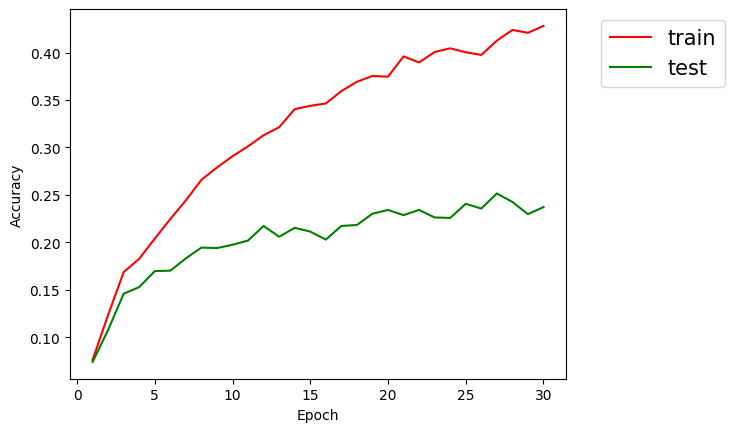

In [84]:
import matplotlib.pyplot as plt

plt.plot(iteration, top_1_acc_train, color='r', label='train')
plt.plot(iteration, top_1_acc_test, color='g', label='test')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize="15")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

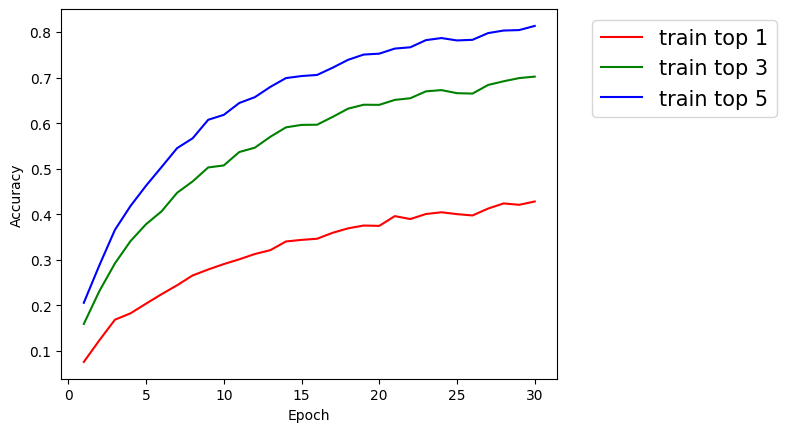

In [89]:
plt.plot(iteration, top_1_acc_train, color='r', label='train top 1')
plt.plot(iteration, top_3_acc_train, color='g', label='train top 3')
plt.plot(iteration, top_5_acc_train, color='b', label='train top 5')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' , fontsize="15")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

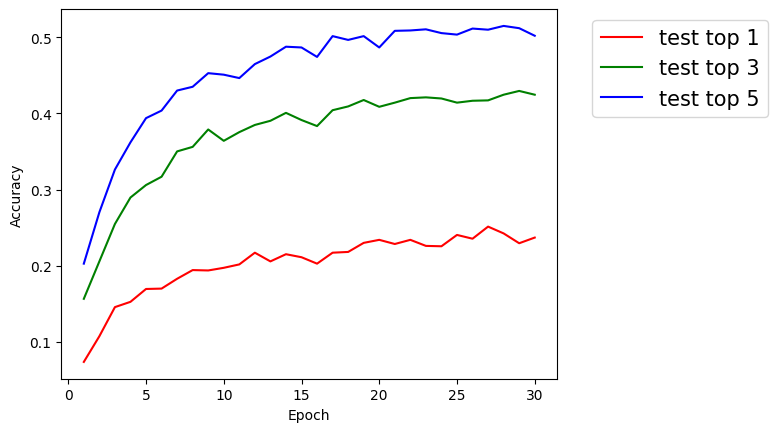

In [90]:
plt.plot(iteration, top_1_acc_test, color='r', label='test top 1')
plt.plot(iteration, top_3_acc_test, color='g', label='test top 3')
plt.plot(iteration, top_5_acc_test, color='b', label='test top 5')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left' , fontsize="15")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

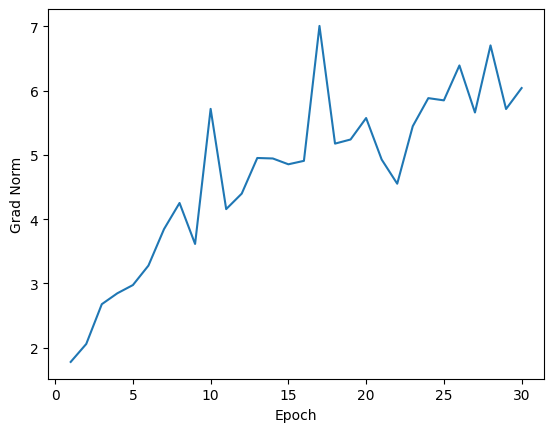

In [91]:
plt.plot(iteration,grad_norm)
plt.xlabel("Epoch")
plt.ylabel("Grad Norm")
plt.show()

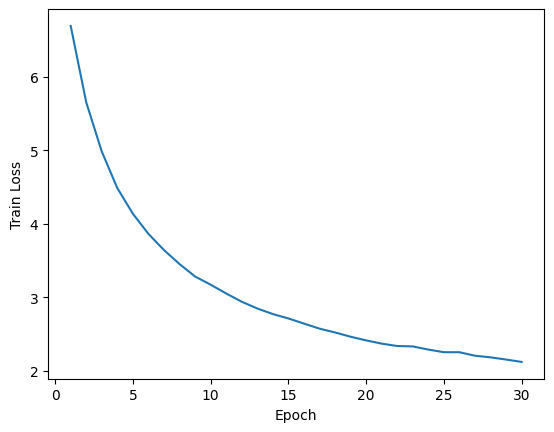

In [92]:
plt.plot(iteration,train_loss)
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.show()

In [ ]:
# print(test_indices)

In [ ]:
i = random.randrange(0, data_to_use)
statement_test = [i]
# dataset_test = DataSet(data)
test_single_sampler = SubsetRandomSampler(statement_test)
dataloader_test = DataLoader(complete_dataset, 1, sampler=test_single_sampler)
# dataloader_test = DataLoader(dataset_test, 1)
# print(statement_test)
print(data[i][0])
print(data[i][1])
# print(inputs)
model.eval()
for (inputs, targets, mask) in dataloader_test:
  with torch.no_grad():
    inputs = inputs.to(device)
    targets = targets.to(device)
    outputs = model(inputs, mask)
    # print(outputs)
    print(outputs.argmax())
    print(torch.topk(outputs,5).indices)
    # if
    print(targets.argmax())
    # if outputs.argmax() == targets.argmax():
    #   p
    #   passed += 1

In [ ]:
# run pre trained model

# DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/mmpy/'
# os.chdir(DATA_DIR)
# model_path = 'model_classification.pth'

# # model
# model = transformer()
# model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# model = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(torch.load(model_path))
# model = model['model']
# model.to(device)